In [40]:
import pandas as pd
import numpy as np
import datetime

import missingno as msno
from plotnine import *
import matplotlib.pyplot as plt
import warnings
import math
import sqlite3
import seaborn as sns
warnings.filterwarnings("ignore")

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error, r2_score

# Machine learning methods 
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

# For evaluating our model's performance
import sklearn.metrics as metrics

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

from sklearn.inspection import (
    permutation_importance,
    partial_dependence, 
    PartialDependenceDisplay, 
    plot_partial_dependence
)

In [2]:
Dat_215_241 = pd.read_csv('Bio_Attendance_Questions_for_modelling.csv')

In [3]:
Dat_215_241.columns

Index(['Unnamed: 0', 'Unnamed: 0_x', 'session_no', 'Member_name',
       'Days_attended', 'question_count', 'Gender', 'Whether_Minister',
       'Term_Details', 'Number_of_Terms', 'State_Name', 'Party_Name',
       'Date_of_Birth', 'Marital_Status', 'Educational_Qualification(s)',
       'Education_coded', 'Other_Profession', 'Previous_Membership',
       'Positions_Held', 'Book_Published', 'Activities', 'Hobbies',
       'Country_Visited', 'Essential_Information', 'Unnamed: 0_y',
       'session_name', 'session_end_date', 'session_start_date',
       'Term_start_year', 'seniority', 'Age', 'no_positions_held',
       'no_books_published', 'attendance_rate', 'participation_rate'],
      dtype='object')

In [4]:
Dat_215_241["Party_Name"].replace({"CONG(I)": "Biju Janata Dal"}, inplace=True)

In [5]:
Political_party_meta_data = pd.read_excel('Political_Parties_meta_data.xlsx')
Political_party_meta_data.head()

,Party_Name,Party_Grouping_1,Ideology,Alliance,Party_Grouping_2
0,Indian National Congress,INC,Centre to Centre-left,UPA,INC
1,Bharatiya Janata Party,BJP,Right-wing,NDA,BJP
2,Bahujan Samaj Party,Other National Parties,Centre-left,SAD+ BSP,Other National Parties
3,Communist Party of India (Marxist),Other National Parties,left-wing,Left Front,Other National Parties
4,Nominated,Nominated,Nominated,Nominated,Nominated candiates


In [6]:
Merged_data = pd.merge(Dat_215_241, Political_party_meta_data, how='left', on=['Party_Name', 'Party_Name'] )
Merged_data.sample(5)

,Unnamed: 0,Unnamed: 0_x,session_no,Member_name,Days_attended,question_count,Gender,Whether_Minister,Term_Details,Number_of_Terms,...,seniority,Age,no_positions_held,no_books_published,attendance_rate,participation_rate,Party_Grouping_1,Ideology,Alliance,Party_Grouping_2
5961,5961,5961,224,m. rama jois,23,2.0,0,0,"6/06/2008 - 25/06/2014 ,",1.0,...,3.0,NaN,10.0,24.0,0.96,0.08,BJP,Right-wing,NDA,BJP
6542,6542,6542,215,praveen rashtrapal,7,0.0,0,0,"3/04/2006 - 02/04/2012 , 03/04/2012 - 02/04/20...",2.0,...,2.0,NaN,15.0,9.0,0.70,0.00,INC,Centre to Centre-left,UPA,INC
428,428,428,220,birendra prasad baishya,26,42.0,0,0,"01/04/2008 - 09/04/2014 ,",1.0,...,2.0,NaN,16.0,NaN,1.00,1.62,North East India,Centre-right,NDA,Regional parties
3298,3298,3298,228Part1,sabir ali,17,29.0,0,0,"01/04/2008 - 15/11/2011 , 16/12/2011 - 09/04/2...",2.0,...,4.0,NaN,9.0,NaN,0.81,1.38,South India,Centre-left,NDA,Regional parties
62,62,62,230,p. bhattacharya,6,0.0,0,0,NaN,NaN,...,NaN,NaN,NaN,NaN,0.60,0.00,NaN,NaN,NaN,NaN


In [7]:
concat_year_alliance =[]
for index, row in Merged_data.iterrows():
    
    if isinstance(row['Alliance'], float):
        
        concat_year_alliance.append(np.nan)

    else:
        d = row.session_end_date[0:4]+row.Alliance

        concat_year_alliance.append(d)
        
Merged_data['concat_year_alliance'] =concat_year_alliance
Merged_data.concat_year_alliance[0:5]

0        NaN
1    2013SP+
2        NaN
3        NaN
4        NaN
Name: concat_year_alliance, dtype: object

In [8]:
Central_gov = ['2009UPA', '2010UPA', '2011UPA', '2012UPA', '2013UPA',\
               '2014NDA', '2015NDA', '2016NDA', '2017NDA', '2018NDA', '2019NDA']
Power = []
for index, row in Merged_data.iterrows(): 
    
    if isinstance(row['concat_year_alliance'], float):
        Power.append(np.nan)
        
    elif row['concat_year_alliance'] in Central_gov:
        Power.append(1)
        
    else:
        Power.append(0)
        
        
Power[0:15]  

[nan, 0, nan, nan, nan, nan, 1, 1, 1, 1, nan, nan, 1, nan, nan]

In [9]:
Merged_data['Power'] = Power

In [10]:
Merged_data.columns

Index(['Unnamed: 0', 'Unnamed: 0_x', 'session_no', 'Member_name',
       'Days_attended', 'question_count', 'Gender', 'Whether_Minister',
       'Term_Details', 'Number_of_Terms', 'State_Name', 'Party_Name',
       'Date_of_Birth', 'Marital_Status', 'Educational_Qualification(s)',
       'Education_coded', 'Other_Profession', 'Previous_Membership',
       'Positions_Held', 'Book_Published', 'Activities', 'Hobbies',
       'Country_Visited', 'Essential_Information', 'Unnamed: 0_y',
       'session_name', 'session_end_date', 'session_start_date',
       'Term_start_year', 'seniority', 'Age', 'no_positions_held',
       'no_books_published', 'attendance_rate', 'participation_rate',
       'Party_Grouping_1', 'Ideology', 'Alliance', 'Party_Grouping_2',
       'concat_year_alliance', 'Power'],
      dtype='object')

In [11]:
Merged_data = Merged_data[['session_no','attendance_rate','participation_rate','Gender', 'Whether_Minister','Marital_Status','Education_coded', 'seniority', 'Age', 'no_positions_held',
       'no_books_published', 'Alliance','Party_Grouping_2', 'Power' ]]
Merged_data.head()

,session_no,attendance_rate,participation_rate,Gender,Whether_Minister,Marital_Status,Education_coded,seniority,Age,no_positions_held,no_books_published,Alliance,Party_Grouping_2,Power
0,230,0.3,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,230,0.3,0.0,1,0,1,4.0,0.0,NaN,3.0,NaN,SP+,Regional parties,0.0
2,230,NaN,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,230,0.9,0.8,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,230,NaN,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
Merged_data.dtypes

session_no             object
attendance_rate       float64
participation_rate    float64
Gender                  int64
Whether_Minister        int64
Marital_Status          int64
Education_coded       float64
seniority             float64
Age                   float64
no_positions_held     float64
no_books_published    float64
Alliance               object
Party_Grouping_2       object
Power                 float64
dtype: object

In [13]:
Merged_data.shape

(7778, 14)

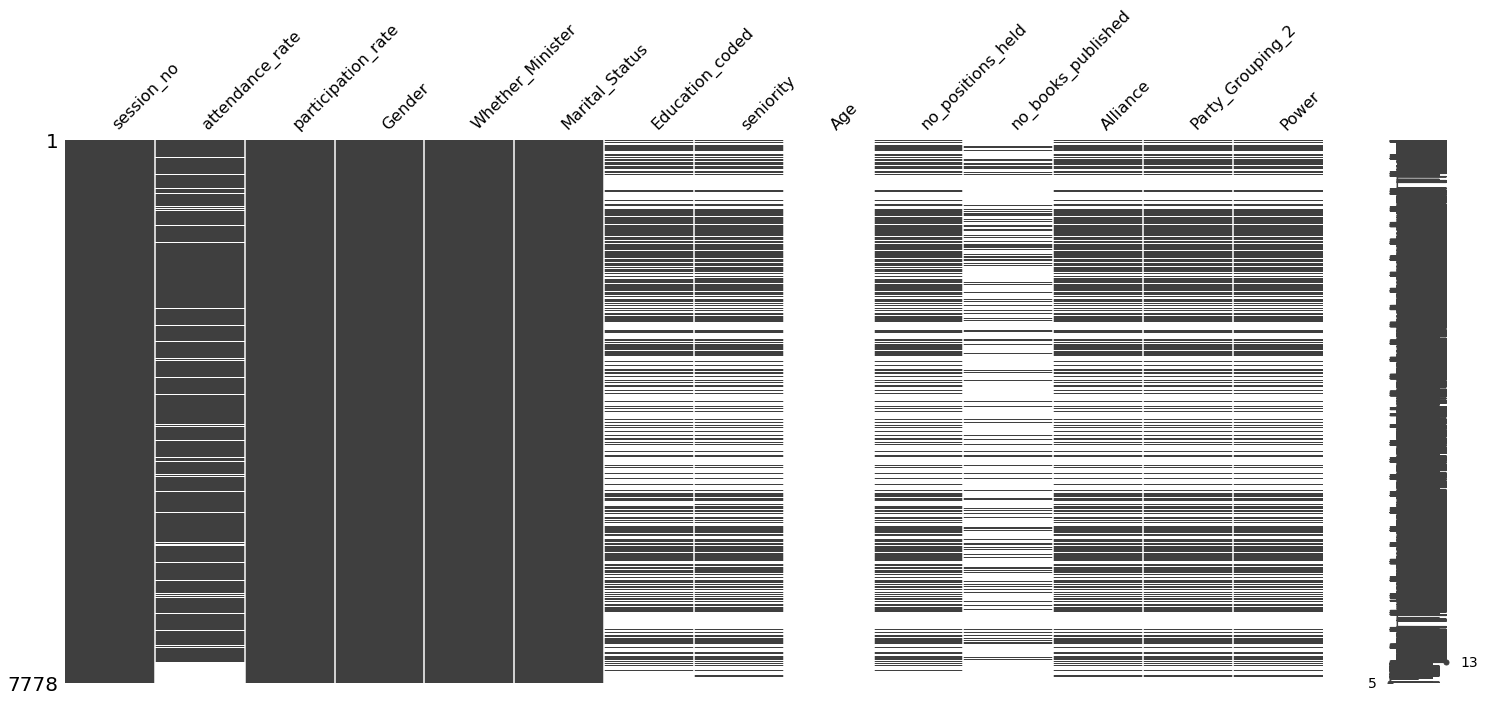

In [14]:
msno.matrix(Merged_data)

In [15]:
session_list = list(set(Merged_data.session_no))

session_NA_dict ={}
for session in session_list:
    df = Merged_data[Merged_data['session_no']==session]
    session_NA_dict[session]=df.Education_coded.isna().sum()


session_NA_dict

{'235': 185,
 '228Part2': 123,
 '215': 62,
 '233': 185,
 '230part2': 126,
 '225Part1': 87,
 '231': 143,
 '240': 233,
 '237': 187,
 '221': 77,
 '224': 92,
 '222': 79,
 '238': 186,
 '223': 85,
 '229': 132,
 '218': 69,
 '241': 235,
 '228Part1': 132,
 '226': 141,
 '230': 125,
 '216': 55,
 '232': 173,
 '236': 187,
 '219Part1': 72,
 '219Part2': 72,
 '225Part2': 120,
 '227': 126,
 '220': 80,
 '234': 188,
 '239': 202,
 '217': 62}

In [16]:
# Delete ministers and all from attendance rate - basically remove NAs
Merged_data_edit1 = Merged_data.dropna(subset=['Education_coded'])
Merged_data_edit1['no_books_published'] = Merged_data_edit1['no_books_published'].fillna(0)

In [17]:
Merged_data_edit1 = Merged_data_edit1[['attendance_rate','participation_rate','Gender','Whether_Minister','Marital_Status','Education_coded', 'seniority', 'no_positions_held',
       'no_books_published', 'Alliance','Party_Grouping_2', 'Power']]

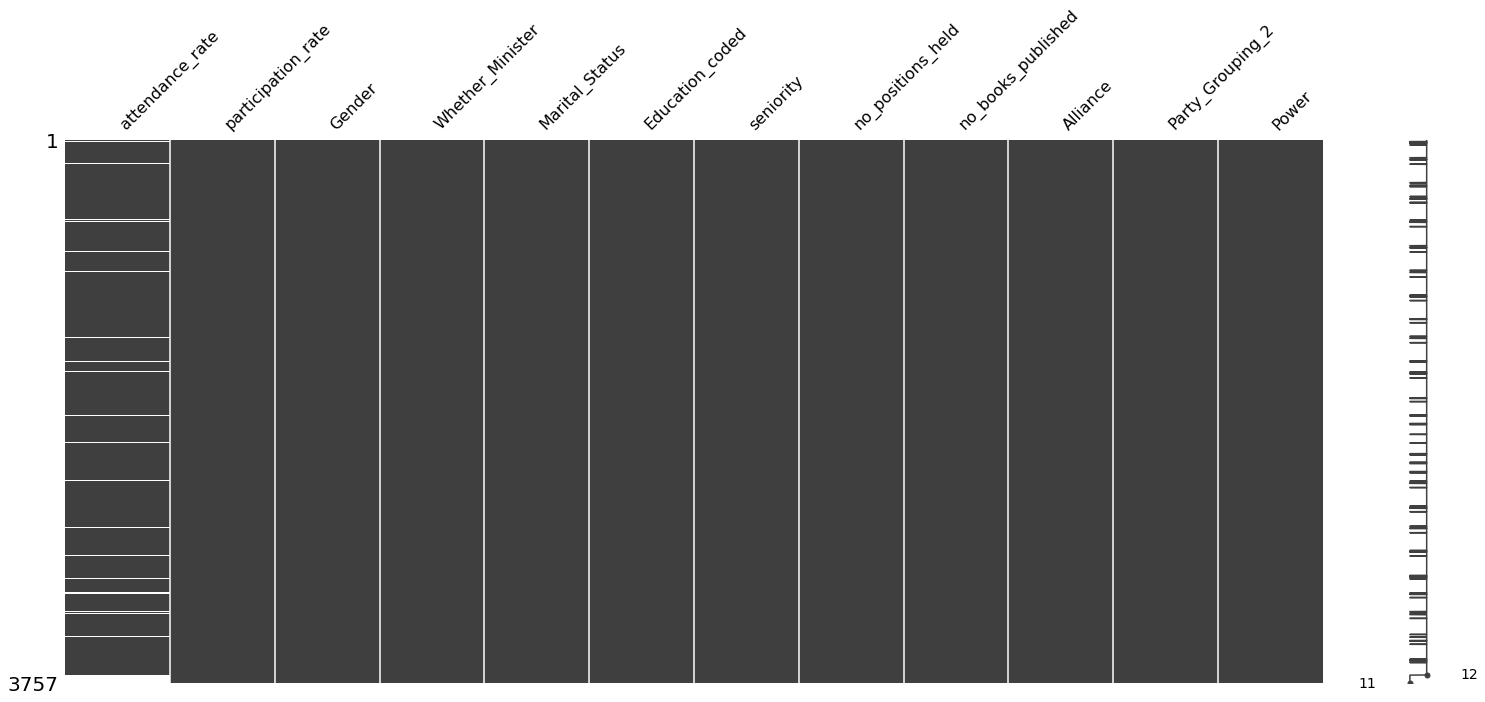

In [18]:
msno.matrix(Merged_data_edit1)

In [19]:
Merged_data_edit1.dtypes

attendance_rate       float64
participation_rate    float64
Gender                  int64
Whether_Minister        int64
Marital_Status          int64
Education_coded       float64
seniority             float64
no_positions_held     float64
no_books_published    float64
Alliance               object
Party_Grouping_2       object
Power                 float64
dtype: object

In [20]:
Merged_data_edit2 = Merged_data_edit1[['attendance_rate','participation_rate','Gender','Whether_Minister','Marital_Status','Education_coded', 'seniority', 'no_positions_held',
       'no_books_published', 'Power']]
correlation_matrix = Merged_data_edit2.corr()

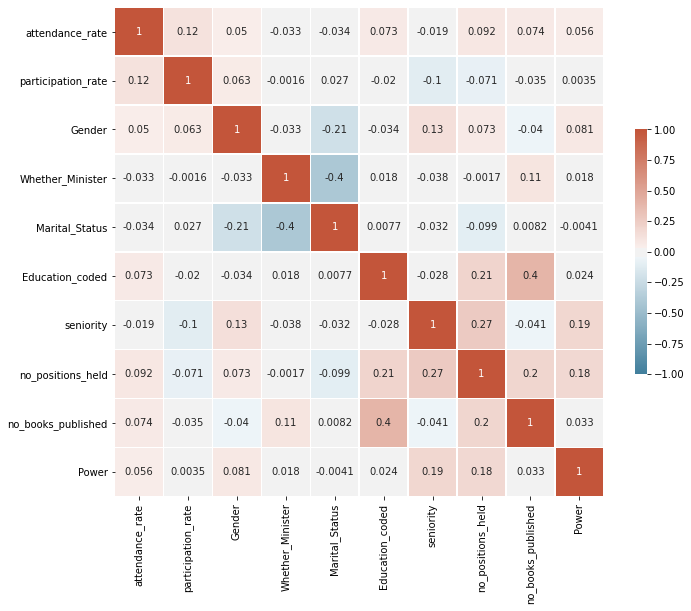

In [21]:
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(correlation_matrix, cmap=cmap, vmax=1, vmin=-1,annot=True, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [22]:
train_data, test_data = train_test_split(Merged_data_edit1,test_size=.25,random_state=42)
train_data.shape[0]/Merged_data_edit1.shape[0]

0.7498003726377429

In [23]:
Merged_data_edit1.isna().sum()

attendance_rate       202
participation_rate      0
Gender                  0
Whether_Minister        0
Marital_Status          0
Education_coded         0
seniority               0
no_positions_held       0
no_books_published      0
Alliance                0
Party_Grouping_2        0
Power                   0
dtype: int64

In [24]:
train_data['Alliance'].replace('TF', 'Other', inplace=True)

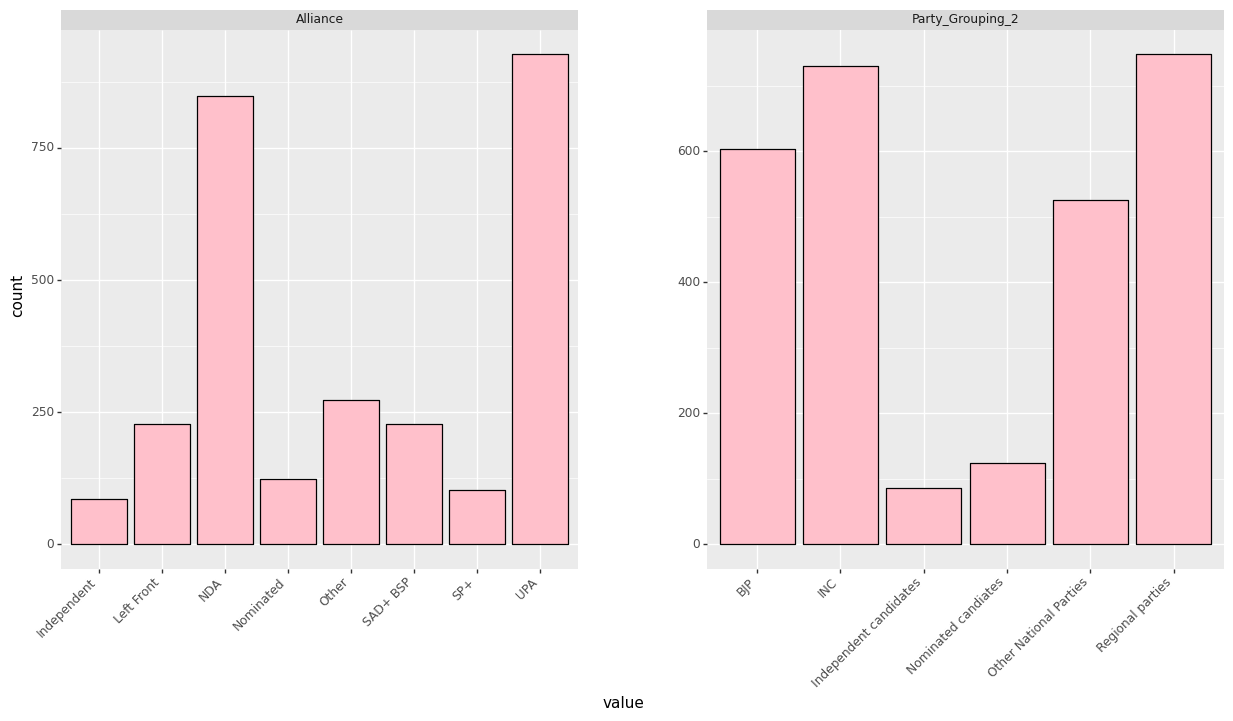

<ggplot: (141137361285)>

In [25]:
d = train_data.select_dtypes(include="O").melt()
(
    ggplot(d,aes(x="value")) +
    geom_bar(color="black", fill="pink") +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(15,7),
          subplots_adjust={'wspace':0.25,
                           'hspace':0.75},
         axis_text_x=element_text(rotation=45, hjust=1))
)

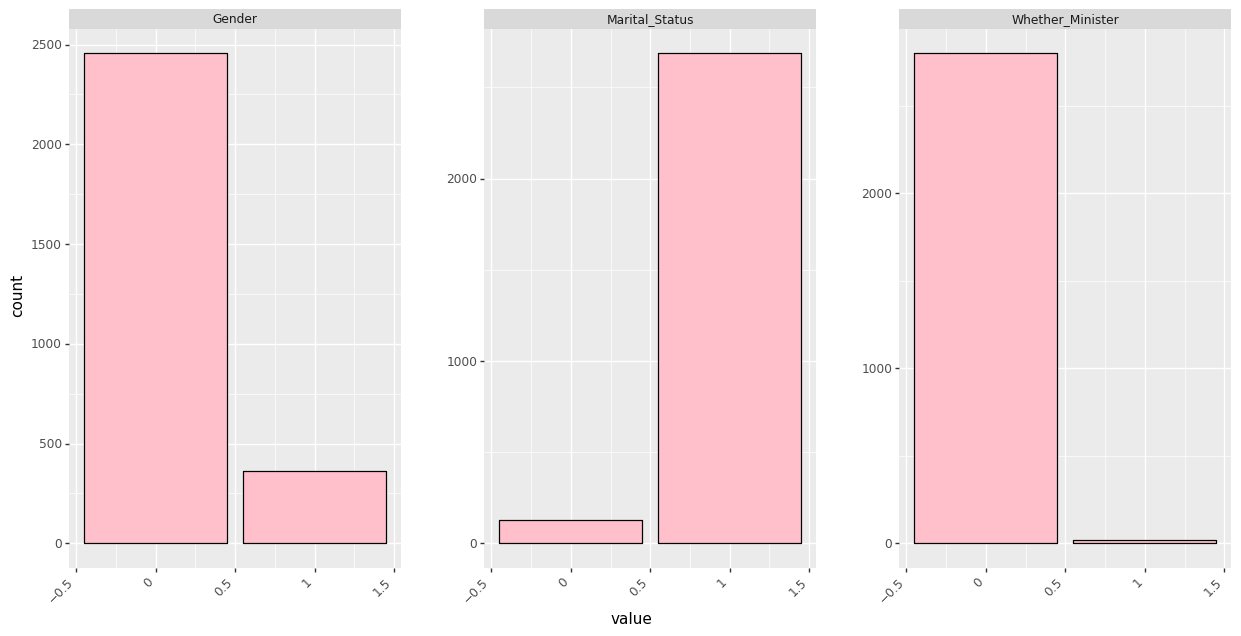

<ggplot: (141140126013)>

In [26]:
d = train_data.select_dtypes(include="int").melt()
(
    ggplot(d,aes(x="value")) +
    geom_bar(color="black", fill="pink") +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(15,7),
          subplots_adjust={'wspace':0.25,
                           'hspace':0.75},
         axis_text_x=element_text(rotation=45, hjust=1))
)

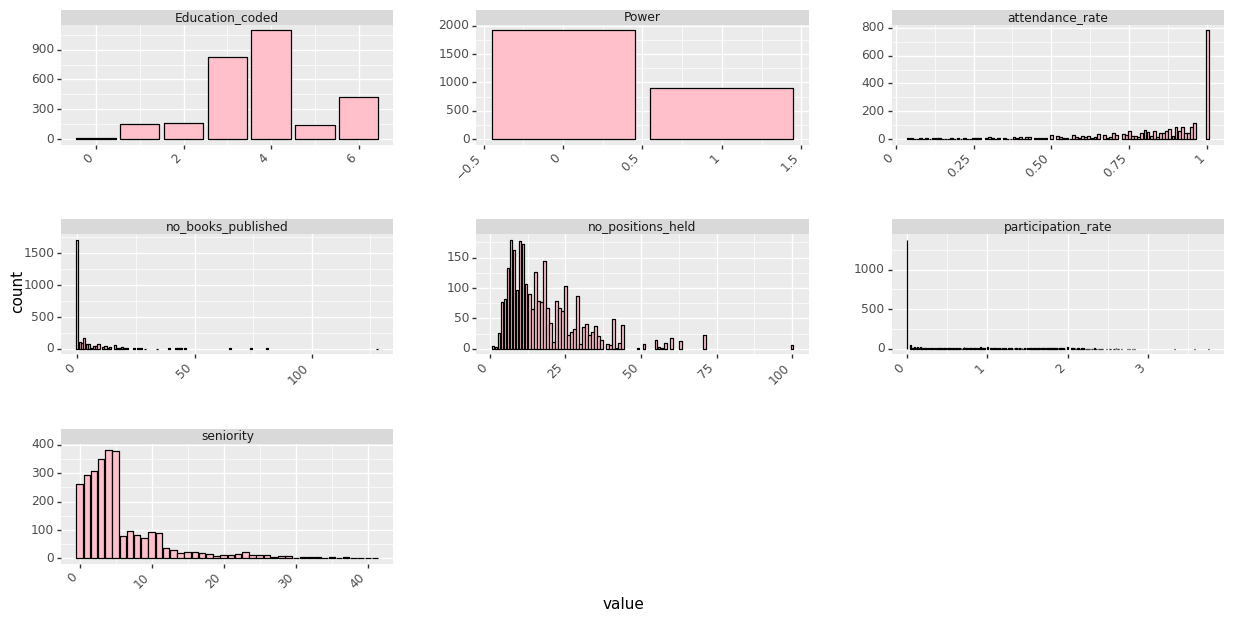

<ggplot: (141140204282)>

In [27]:
d = train_data.select_dtypes(include="float").melt()
(
    ggplot(d,aes(x="value")) +
    geom_bar(color="black", fill="pink") +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(15,7),
          subplots_adjust={'wspace':0.25,
                           'hspace':0.75},
         axis_text_x=element_text(rotation=45, hjust=1))
)

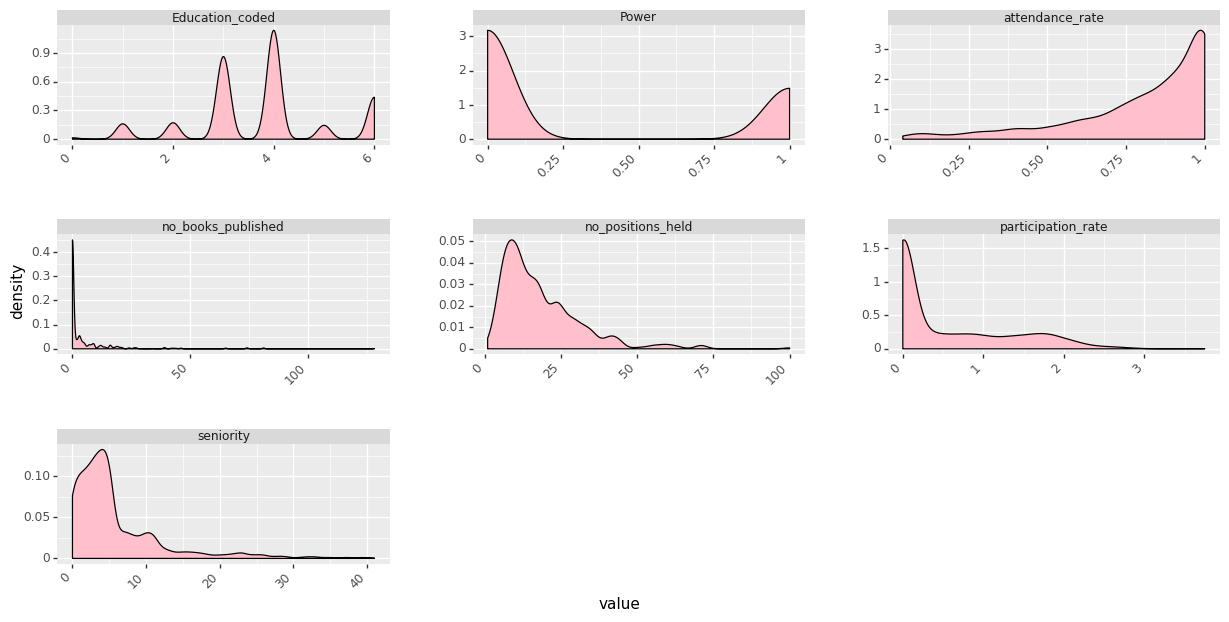

<ggplot: (141141049670)>

In [28]:
d = train_data.select_dtypes(include="float").melt()
(
    ggplot(d,aes(x="value")) +
    geom_density(color="black", fill="pink") +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(15,7),
          subplots_adjust={'wspace':0.25,
                           'hspace':0.75},
         axis_text_x=element_text(rotation=45, hjust=1))
)

In [29]:
train_data['log_seniority']= np.log10(train_data['seniority']+1)
train_data['log_positions_held']= np.log10(train_data['no_positions_held']+1)

In [30]:
#Alliance
Alliance_dummies = pd.get_dummies(train_data.Alliance)
#Alliance_dummies = Alliance_dummies.drop(['Alliance'],axis=1) # Baseline
train_data = pd.concat([train_data.drop(['Alliance'],axis=1),Alliance_dummies],axis=1)
train_data.head()

,attendance_rate,participation_rate,Gender,Whether_Minister,Marital_Status,Education_coded,seniority,no_positions_held,no_books_published,Party_Grouping_2,...,log_seniority,log_positions_held,Independent,Left Front,NDA,Nominated,Other,SAD+ BSP,SP+,UPA
2517,0.91,1.13,0,0,1,3.0,2.0,15.0,0.0,Regional parties,...,0.477121,1.204120,0,0,1,0,0,0,0,0
2019,0.93,0.00,1,0,1,4.0,2.0,10.0,0.0,Nominated candiates,...,0.477121,1.041393,0,0,0,1,0,0,0,0
7610,NaN,0.11,0,0,1,6.0,15.0,12.0,4.0,Nominated candiates,...,1.204120,1.113943,0,0,0,1,0,0,0,0
3465,0.94,1.50,0,0,1,5.0,5.0,6.0,12.0,Regional parties,...,0.778151,0.845098,0,0,0,0,1,0,0,0
3264,0.86,0.00,0,0,1,4.0,4.0,63.0,1.0,Regional parties,...,0.698970,1.806180,0,0,1,0,0,0,0,0


In [31]:
#Party_Grouping_2
Party_Grouping_dummies = pd.get_dummies(train_data.Party_Grouping_2)
train_data = pd.concat([train_data.drop(['Party_Grouping_2'],axis=1),Party_Grouping_dummies],axis=1)
train_data.head()

,attendance_rate,participation_rate,Gender,Whether_Minister,Marital_Status,Education_coded,seniority,no_positions_held,no_books_published,Power,...,Other,SAD+ BSP,SP+,UPA,BJP,INC,Independent candidates,Nominated candiates,Other National Parties,Regional parties
2517,0.91,1.13,0,0,1,3.0,2.0,15.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2019,0.93,0.00,1,0,1,4.0,2.0,10.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
7610,NaN,0.11,0,0,1,6.0,15.0,12.0,4.0,0.0,...,0,0,0,0,0,0,0,1,0,0
3465,0.94,1.50,0,0,1,5.0,5.0,6.0,12.0,0.0,...,1,0,0,0,0,0,0,0,0,1
3264,0.86,0.00,0,0,1,4.0,4.0,63.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,1


In [32]:
train_data.drop(columns=['Marital_Status', 'Whether_Minister', 'seniority', 'no_positions_held' ], inplace=True)
train_data.head()

,attendance_rate,participation_rate,Gender,Education_coded,no_books_published,Power,log_seniority,log_positions_held,Independent,Left Front,...,Other,SAD+ BSP,SP+,UPA,BJP,INC,Independent candidates,Nominated candiates,Other National Parties,Regional parties
2517,0.91,1.13,0,3.0,0.0,0.0,0.477121,1.204120,0,0,...,0,0,0,0,0,0,0,0,0,1
2019,0.93,0.00,1,4.0,0.0,0.0,0.477121,1.041393,0,0,...,0,0,0,0,0,0,0,1,0,0
7610,NaN,0.11,0,6.0,4.0,0.0,1.204120,1.113943,0,0,...,0,0,0,0,0,0,0,1,0,0
3465,0.94,1.50,0,5.0,12.0,0.0,0.778151,0.845098,0,0,...,1,0,0,0,0,0,0,0,0,1
3264,0.86,0.00,0,4.0,1.0,0.0,0.698970,1.806180,0,0,...,0,0,0,0,0,0,0,0,0,1


In [33]:
for index, row in train_data.iterrows():
    
    if row['participation_rate']==0:
        row['participation_rate']=0
        
    if row['participation_rate']>0:
        row['participation_rate']=1
        
train_data.head()

,attendance_rate,participation_rate,Gender,Education_coded,no_books_published,Power,log_seniority,log_positions_held,Independent,Left Front,...,Other,SAD+ BSP,SP+,UPA,BJP,INC,Independent candidates,Nominated candiates,Other National Parties,Regional parties
2517,0.91,1.13,0,3.0,0.0,0.0,0.477121,1.204120,0,0,...,0,0,0,0,0,0,0,0,0,1
2019,0.93,0.00,1,4.0,0.0,0.0,0.477121,1.041393,0,0,...,0,0,0,0,0,0,0,1,0,0
7610,NaN,0.11,0,6.0,4.0,0.0,1.204120,1.113943,0,0,...,0,0,0,0,0,0,0,1,0,0
3465,0.94,1.50,0,5.0,12.0,0.0,0.778151,0.845098,0,0,...,1,0,0,0,0,0,0,0,0,1
3264,0.86,0.00,0,4.0,1.0,0.0,0.698970,1.806180,0,0,...,0,0,0,0,0,0,0,0,0,1


In [34]:
list(train_data.columns)

['attendance_rate',
 'participation_rate',
 'Gender',
 'Education_coded',
 'no_books_published',
 'Power',
 'log_seniority',
 'log_positions_held',
 'Independent',
 'Left Front',
 'NDA',
 'Nominated',
 'Other',
 'SAD+ BSP',
 'SP+',
 'UPA',
 'BJP',
 'INC',
 'Independent candidates',
 'Nominated candiates',
 'Other National Parties',
 'Regional parties']

In [35]:
knn = KNNImputer(n_neighbors=5)
knn.fit(train_data)
train_data = pd.DataFrame(knn.transform(train_data), columns=['attendance_rate',
 'participation_rate',
 'Gender',
 'Education_coded',
 'no_books_published',
 'Power',
 'log_seniority',
 'log_positions_held',
 'Independent',
 'Left Front',
 'NDA',
 'Nominated',
 'Other',
 'SAD+ BSP',
 'SP+',
 'UPA',
 'BJP',
 'INC',
 'Independent candidates',
 'Nominated candiates',
 'Other National Parties',
 'Regional parties'])#Missing values imputed
train_data.head()

,attendance_rate,participation_rate,Gender,Education_coded,no_books_published,Power,log_seniority,log_positions_held,Independent,Left Front,...,Other,SAD+ BSP,SP+,UPA,BJP,INC,Independent candidates,Nominated candiates,Other National Parties,Regional parties
0,0.910,1.13,0.0,3.0,0.0,0.0,0.477121,1.204120,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.930,0.00,1.0,4.0,0.0,0.0,0.477121,1.041393,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.828,0.11,0.0,6.0,4.0,0.0,1.204120,1.113943,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.940,1.50,0.0,5.0,12.0,0.0,0.778151,0.845098,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.860,0.00,0.0,4.0,1.0,0.0,0.698970,1.806180,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [36]:
train_data.columns

Index(['attendance_rate', 'participation_rate', 'Gender', 'Education_coded',
       'no_books_published', 'Power', 'log_seniority', 'log_positions_held',
       'Independent', 'Left Front', 'NDA', 'Nominated', 'Other', 'SAD+ BSP',
       'SP+', 'UPA', 'BJP', 'INC', 'Independent candidates',
       'Nominated candiates', 'Other National Parties', 'Regional parties'],
      dtype='object')

# High-Level Processing of Test Data

In [37]:
test_data['Alliance'].replace('TF', 'Other', inplace=True)
test_data['log_seniority']= np.log10(test_data['seniority']+1)
test_data['log_positions_held']= np.log10(test_data['no_positions_held']+1)


#Alliance
Alliance_dummies = pd.get_dummies(test_data.Alliance)
test_data = pd.concat([test_data.drop(['Alliance'],axis=1),Alliance_dummies],axis=1)

#Party_Grouping_2
Party_Grouping_dummies = pd.get_dummies(test_data.Party_Grouping_2)
test_data = pd.concat([test_data.drop(['Party_Grouping_2'],axis=1),Party_Grouping_dummies],axis=1)


test_data.drop(columns=['Marital_Status', 'Whether_Minister', 'seniority', 'no_positions_held' ], inplace=True)

for index, row in test_data.iterrows():
    
    if row['participation_rate']==0:
        row['participation_rate']=0
        
    if row['participation_rate']>0:
        row['participation_rate']=1


test_data = pd.DataFrame(knn.transform(test_data), columns=['attendance_rate','participation_rate','Gender',\
 'Education_coded','no_books_published','Power','log_seniority','log_positions_held','Independent',\
 'Left Front','NDA','Nominated','Other','SAD+ BSP','SP+','UPA','BJP',\
 'INC','Independent candidates','Nominated candiates','Other National Parties','Regional parties'])#Missing values imputed


In [38]:
train_X = train_data.drop(columns=['participation_rate'])
test_X  = test_data.drop(columns=['participation_rate'])
train_y = train_data[['participation_rate']]
test_y  = test_data[['participation_rate']]

In [59]:
# (1) Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

# (2) Next specify the preprocessing steps
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(), ['attendance_rate', 'Gender', 'Education_coded',
       'no_books_published', 'Power', 'log_seniority', 'log_positions_held',
       'Independent', 'Left Front', 'NDA', 'Nominated', 'Other', 'SAD+ BSP',
       'SP+', 'UPA', 'BJP', 'INC', 'Independent candidates',
       'Nominated candiates', 'Other National Parties', 'Regional parties'])])


# (3) Next Let's create our model pipe (note for the model we leave none as a placeholder)
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])


# (4) Specify the models and their repsective tuning parameters. 
# Note the naming convention here to reference the model key
search_space = [
    # Linear Model
    {'model': [GaussianNB()]},
    
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[10,15,20,25]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[1,2,3,4]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[1,2,3,4],
     'model__n_estimators':[500,1000,1250]},
    {
     'model': [XGBClassifier()]
    }
]


# (5) Put it all together in the grid search
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)

# (6) Fit the model to the training data
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['attendance_rate',
                                                                          'Gender',
                                                                          'Education_coded',
                                                                          'no_books_published',
                                                                          'Power',
                                                                          'log_seniority',
                                                                          'log_positions_held',
                                                                         

In [60]:
search.best_score_

-0.33971447558955165

In [61]:
search.best_params_

{'model': BaggingRegressor()}

In [62]:
mod = search.best_estimator_

In [63]:
mod

Pipeline(steps=[('pre_process',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['attendance_rate', 'Gender',
                                                   'Education_coded',
                                                   'no_books_published',
                                                   'Power', 'log_seniority',
                                                   'log_positions_held',
                                                   'Independent', 'Left Front',
                                                   'NDA', 'Nominated', 'Other',
                                                   'SAD+ BSP', 'SP+', 'UPA',
                                                   'BJP', 'INC',
                                                   'Independent candidates',
                                                   'Nominated candiates',
                                                   'Other National Pa

# Performance

In [64]:
pred_y = search.predict(test_X)

In [65]:
metrics.mean_squared_error(test_y,pred_y)

0.2588687578579917

In [66]:
metrics.r2_score(test_y,pred_y)

0.46731779393471906

# Permutation Importance

In [60]:
vi = permutation_importance(mod,train_X,train_y,n_repeats=25)

In [61]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,no_positions_held,0.764236,0.017809,0.728618,0.799854
1,seniority,0.751238,0.015790,0.719658,0.782818
2,attendance_rate,0.494498,0.013971,0.466555,0.522441
3,Education_coded,0.408909,0.014263,0.380384,0.437434
4,no_books_published,0.317157,0.009556,0.298045,0.336268
5,Gender,0.150926,0.007858,0.135211,0.166641
6,Marital_Status,0.006211,0.000591,0.005028,0.007394
7,Whether_Minister,0.000509,0.000043,0.000422,0.000596


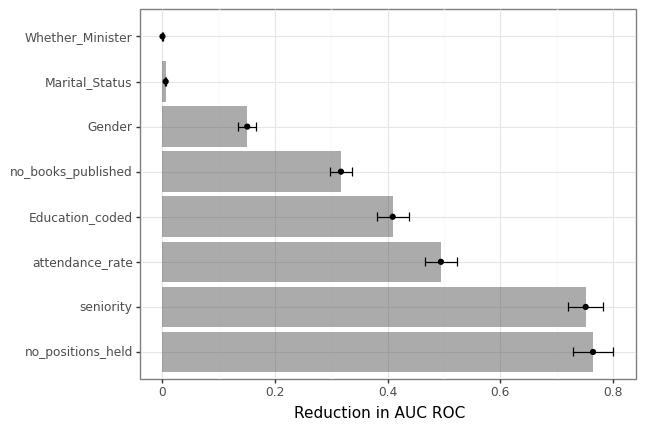

<ggplot: (171014055361)>

In [62]:
# Plot
(
    ggplot(vi_dat,
          aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)

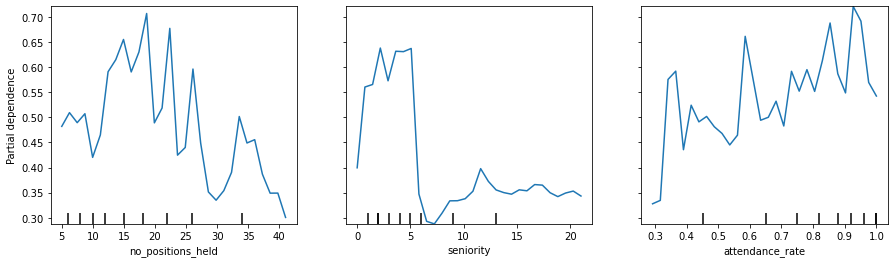

In [63]:
features = ['no_positions_held','seniority','attendance_rate']

# Calculate the partial dependency
fig, ax = plt.subplots(figsize=(15, 4))
display = plot_partial_dependence(
    mod, train_X, features,n_cols=5,
    n_jobs=4, grid_resolution=30,ax=ax
)